Here we are interested in the effect of composing numerous convolution filters with very small kernels. 

We'd like to visualize the distribution of kernel and it's spectral effect 

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Spectral space derivation

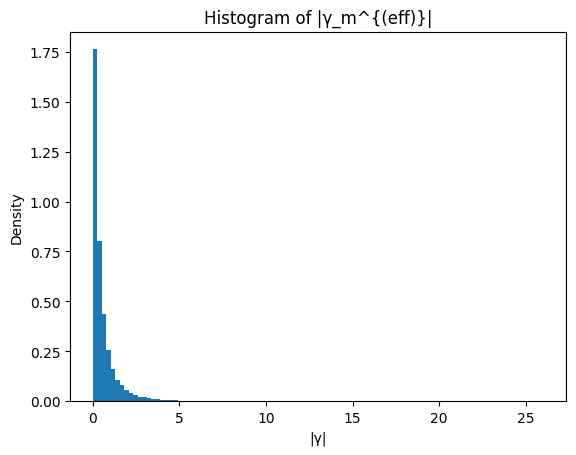

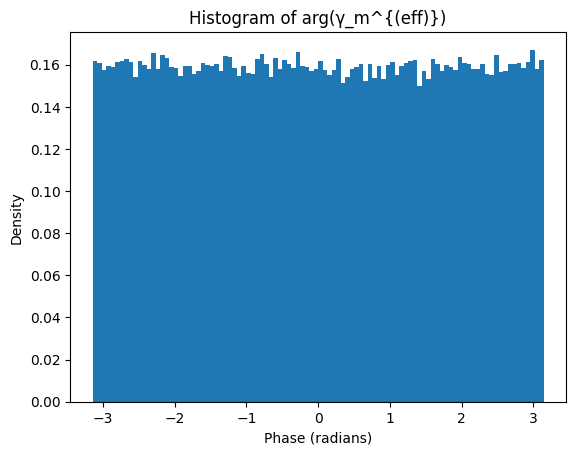

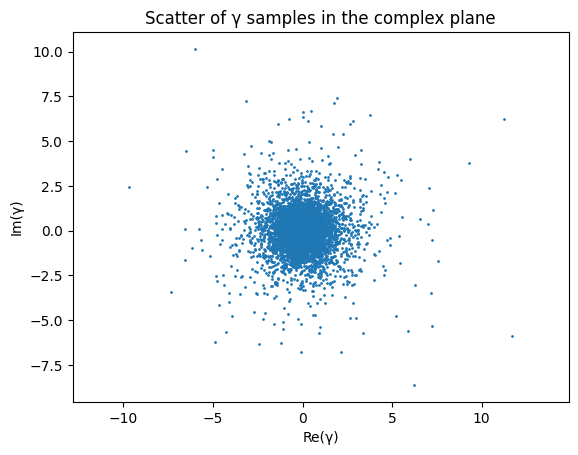

In [5]:

# 1) Parameters
a = 1.0           # uniform bound
L = 5             # number of layers
m = 10             # frequency index
N = 100           # signal length
theta = 2 * np.pi * m / N

num_samples = 200_000  # total samples

# 2) Sample weights: shape (num_samples, L)
w0  = torch.rand(num_samples, L) * 2*a - a
w1  = torch.rand(num_samples, L) * 2*a - a
wm1 = torch.rand(num_samples, L) * 2*a - a  # w_{-1}

# 3) Compute each layer’s Fourier‐combination s^(l)
#    Note: broadcasting a Python complex onto a torch tensor yields a complex64 tensor.
s = w0 + w1 * np.exp(-1j * theta) + wm1 * np.exp(1j * theta)  

# 4) Product across layers → γ samples
gamma = torch.prod(s, dim=1)  

# 5) Convert to NumPy for plotting
gamma_np = gamma.numpy()
mag = np.abs(gamma_np)
phase = np.angle(gamma_np)

# 6a) Histogram of |γ|
plt.figure()
plt.hist(mag, bins=100, density=True)
plt.title('Histogram of |γ_m^{(eff)}|')
plt.xlabel('|γ|')
plt.ylabel('Density')

# 6b) Histogram of arg(γ)
plt.figure()
plt.hist(phase, bins=100, density=True)
plt.title('Histogram of arg(γ_m^{(eff)})')
plt.xlabel('Phase (radians)')
plt.ylabel('Density')

# 6c) Scatter of complex samples (first 20k for speed)
plt.figure()
plt.scatter(gamma_np.real[:20_000], gamma_np.imag[:20_000], s=1)
plt.title('Scatter of γ samples in the complex plane')
plt.xlabel('Re(γ)')
plt.ylabel('Im(γ)')
plt.axis('equal')

plt.show()

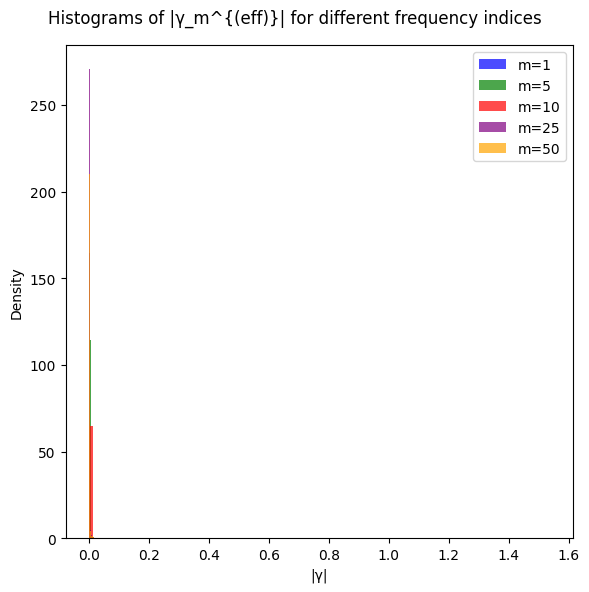

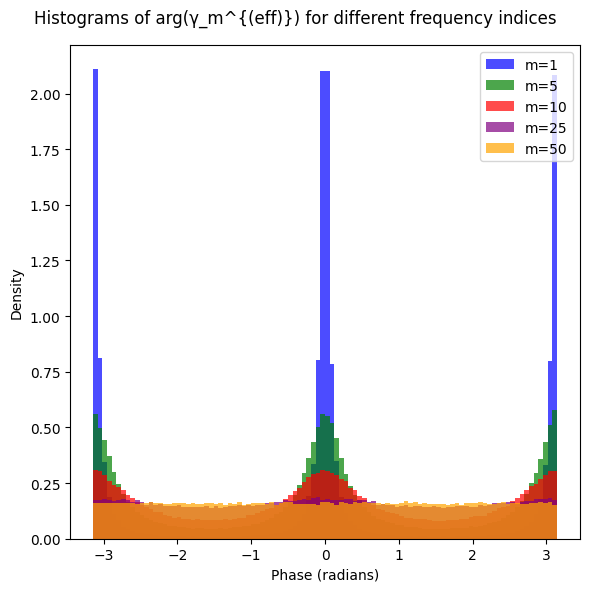

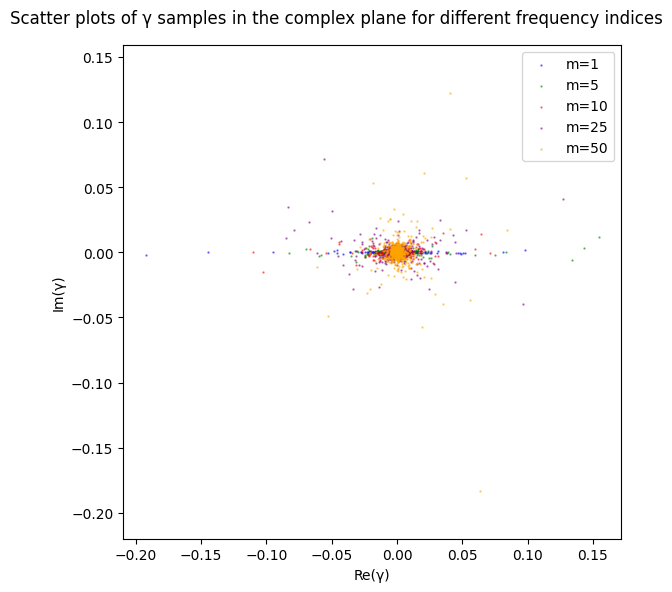

In [ ]:
import math
fan_in = 3
# 1) Parameters
a = 1.0 / math.sqrt(fan_in)          # uniform bound
L = 10             # number of layers
N = 1000          # signal length
num_samples = 200_000  # total samples

# List of frequency indices to analyze
m_values = [1, 5, 10, 25, 50]
colors = ['blue', 'green', 'red', 'purple', 'orange']  # colors for different m values

# Create a figure with single plots for each visualization type
fig_mag = plt.figure(figsize=(6, 6))
ax_mag = fig_mag.add_subplot(1, 1, 1)
fig_phase = plt.figure(figsize=(6, 6))
ax_phase = fig_phase.add_subplot(1, 1, 1)
fig_scatter = plt.figure(figsize=(6, 6))
ax_scatter = fig_scatter.add_subplot(1, 1, 1)

for i, m in enumerate(m_values):
    # Calculate theta for this frequency
    theta = 2 * np.pi * m / N
    # 2) Sample weights: shape (num_samples, L)
    w0  = torch.rand(num_samples, L) * 2*a - a
    w1  = torch.rand(num_samples, L) * 2*a - a
    wm1 = torch.rand(num_samples, L) * 2*a - a  # w_{-1}
    # 3) Compute each layer's Fourier‐combination s^(l)
    s = w0 + w1 * np.exp(-1j * theta) + wm1 * np.exp(1j * theta)  
    # 4) Product across layers → γ samples
    gamma = torch.prod(s, dim=1)  
    # 5) Convert to NumPy for plotting
    gamma_np = gamma.numpy()
    mag = np.abs(gamma_np)
    phase = np.angle(gamma_np)
    
    # 6a) Histogram of |γ|
    ax_mag.hist(mag, bins=100, density=True, alpha=0.7, color=colors[i], label=f'm={m}')
    
    # 6b) Histogram of arg(γ)
    ax_phase.hist(phase, bins=100, density=True, alpha=0.7, color=colors[i], label=f'm={m}')
    
    # 6c) Scatter of complex samples (first 10k for speed)
    ax_scatter.scatter(gamma_np.real[:10_000], gamma_np.imag[:10_000], s=0.5, color=colors[i], alpha=0.5, label=f'm={m}')

# Add labels and legends
ax_mag.set_ylabel('Density')
ax_mag.set_xlabel('|γ|')
ax_mag.legend()

ax_phase.set_ylabel('Density')
ax_phase.set_xlabel('Phase (radians)')
ax_phase.legend()

ax_scatter.set_ylabel('Im(γ)')
ax_scatter.set_xlabel('Re(γ)')
ax_scatter.axis('equal')
ax_scatter.legend()

fig_mag.suptitle('Histograms of |γ_m^{(eff)}| for different frequency indices')
fig_phase.suptitle('Histograms of arg(γ_m^{(eff)}) for different frequency indices')
fig_scatter.suptitle('Scatter plots of γ samples in the complex plane for different frequency indices')

fig_mag.tight_layout()
fig_phase.tight_layout()
fig_scatter.tight_layout()

plt.show()

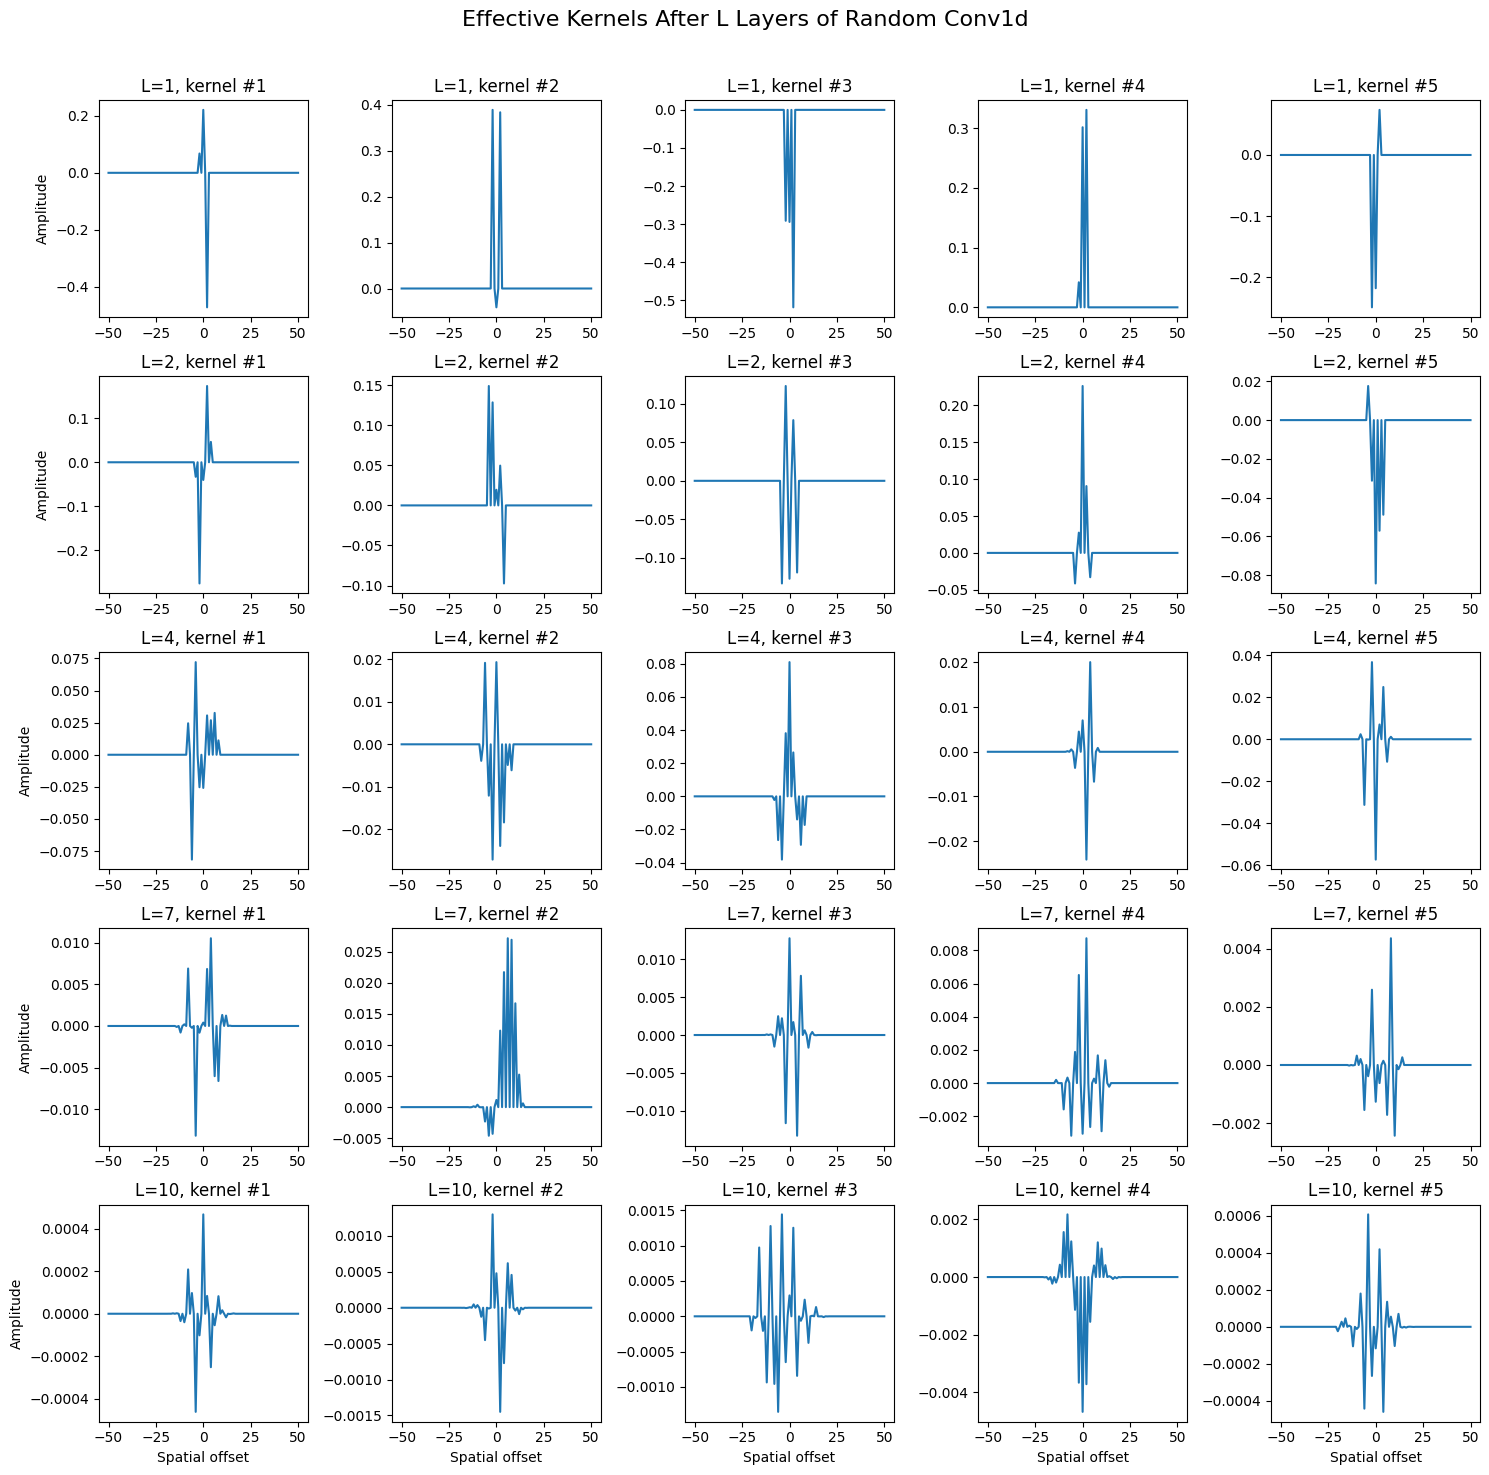

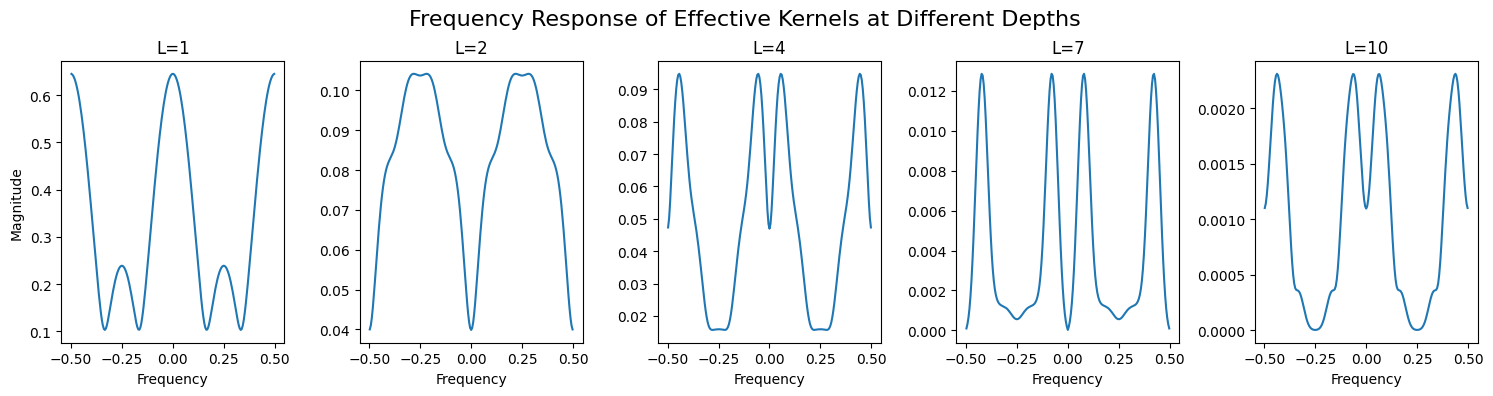

In [11]:
# %% Visualizing the effective kernel of conv1d with random weights through L layers

import numpy as np
import matplotlib.pyplot as plt
import torch

# Parameters
L = 10             # number of layers
N = 1000           # signal length
fan_in = 3         # number of input channels per layer
a = 1.0 / np.sqrt(fan_in)  # uniform bound for weight initialization
kernel_size = 3    # standard 3-tap filter (w_{-1}, w_0, w_1)

# Create figure for effective kernel visualization
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Effective Kernels After L Layers of Random Conv1d', fontsize=16)

# Spatial domain points to visualize
spatial_points = 100
x = np.linspace(0, N-1, spatial_points)

# Generate multiple random initializations
num_kernels = 5  # number of random kernels to show per layer depth

# Layer depths to visualize
layer_depths = [1, 2, 4, 7, 10]

for i, depth in enumerate(layer_depths):
    for j in range(num_kernels):
        # Initialize random kernels for each layer
        # Each kernel has 3 weights: w_{-1}, w_0, w_1
        kernels = torch.rand(depth, 3) * 2*a - a
        
        # Compute effective kernel through convolution
        # Start with a delta function
        effective_kernel = torch.zeros(2*N+1)
        effective_kernel[N] = 1.0  # delta at center
        
        # Apply each layer's kernel
        for layer in range(depth):
            # Extract weights
            w_m1, w_0, w_1 = kernels[layer]
            
            # Perform convolution
            new_kernel = torch.zeros_like(effective_kernel)
            new_kernel[:-2] += w_m1 * effective_kernel[2:]    # w_{-1} contribution
            new_kernel[1:-1] += w_0 * effective_kernel[1:-1]  # w_0 contribution
            new_kernel[2:] += w_1 * effective_kernel[:-2]     # w_1 contribution
            
            effective_kernel = new_kernel
        
        # Convert to numpy for plotting
        kernel_np = effective_kernel.numpy()
        
        # Plot the central portion of the effective kernel
        center = N
        window = 50  # show +/- 50 points around center
        plot_kernel = kernel_np[center-window:center+window+1]
        plot_x = np.arange(-window, window+1)
        
        # Plot in the appropriate subplot
        axes[i, j].plot(plot_x, plot_kernel)
        axes[i, j].set_title(f'L={depth}, kernel #{j+1}')
        
        if j == 0:
            axes[i, j].set_ylabel('Amplitude')
        if i == 4:
            axes[i, j].set_xlabel('Spatial offset')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Also visualize the frequency response of the effective kernels
fig_freq, axes_freq = plt.subplots(1, 5, figsize=(15, 4))
fig_freq.suptitle('Frequency Response of Effective Kernels at Different Depths', fontsize=16)

# Generate one kernel per depth for frequency analysis
for i, depth in enumerate(layer_depths):
    # Initialize random kernels
    kernels = torch.rand(depth, 3) * 2*a - a
    
    # Compute effective kernel
    effective_kernel = torch.zeros(2*N+1)
    effective_kernel[N] = 1.0  # delta at center
    
    for layer in range(depth):
        w_m1, w_0, w_1 = kernels[layer]
        new_kernel = torch.zeros_like(effective_kernel)
        new_kernel[:-2] += w_m1 * effective_kernel[2:]
        new_kernel[1:-1] += w_0 * effective_kernel[1:-1]
        new_kernel[2:] += w_1 * effective_kernel[:-2]
        effective_kernel = new_kernel
    
    # Take central portion for FFT
    center = N
    window = 100
    kernel_for_fft = effective_kernel[center-window:center+window+1].numpy()
    
    # Compute frequency response
    freq_response = np.abs(np.fft.fftshift(np.fft.fft(kernel_for_fft)))
    freq_axis = np.fft.fftshift(np.fft.fftfreq(len(kernel_for_fft)))
    
    # Plot
    axes_freq[i].plot(freq_axis, freq_response)
    axes_freq[i].set_title(f'L={depth}')
    axes_freq[i].set_xlabel('Frequency')
    
    if i == 0:
        axes_freq[i].set_ylabel('Magnitude')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


In [85]:
import torch
import torch.nn.functional as F

def compose_1d(k1: torch.Tensor, k2: torch.Tensor) -> torch.Tensor:
    """
    k1: Tensor of shape (L1,)
    k2: Tensor of shape (L2,)
    returns: Tensor of shape (L1+L2-1,)
    """
    L1, L2 = k1.numel(), k2.numel()
    # 1) Flip k1 so that F.conv1d (which actually does cross-correlation)
    #    implements a true convolution of k2 * k1.
    k1_flip = k1.flip(0)
    # 2) Embed both as (batch=1, channel=1, length)
    k2_b = k2.view(1, 1, L2)
    k1_b = k1_flip.view(1, 1, L1)
    # 3) Pad k2 on both sides so that we get a "full" convolution.
    pad = (L1 - 1, L1 - 1)
    k2_padded = F.pad(k2_b, pad)
    # 4) Convolve
    k_eff = F.conv1d(k2_padded, k1_b)   # → shape (1, 1, L1+L2-1)
    return k_eff.view(-1)

def test_compose_1d(N=100, kernel_size=3, dtype=torch.double):
    # make a random "signal"
    torch.manual_seed(42)  # for reproducibility
    x = torch.randn(1, 1, N, dtype=dtype)   # batch=1, channel=1, length=N
    k1 = torch.randn(kernel_size, dtype=dtype)#torch.tensor([1., 2., 3.], dtype=dtype)             # L1 = 3
    k2 = torch.randn(kernel_size, dtype=dtype)#torch.tensor([1., 3., 2.], dtype=dtype)         # L2 = 3
    
    # 1) sequential convolution (no padding, stride=1)
    k1_b = k1.view(1,1,-1)
    k2_b = k2.view(1,1,-1)
    out_seq = F.conv1d(F.conv1d(x, k1_b), k2_b)
    # 2) single convolution with the effective kernel
    k_eff = compose_1d(k1, k2)
    k_eff_b = k_eff.view(1,1,-1)
    out_eff = F.conv1d(x, k_eff_b)
    # compare
    print("sequential:", out_seq.shape)
    print("single-ker:", out_eff.shape)
    print("difference max abs:", (out_seq - out_eff).abs().max().item())
    assert torch.allclose(out_seq, out_eff), "They differ!"
    print("✅ out_seq and out_eff match exactly")
    return True

# Run the test
test_compose_1d(dtype=torch.float32)
test_compose_1d(dtype=torch.double)

# toy example
k1 = torch.tensor([1., 2., 3.])             # L1 = 2
k2 = torch.tensor([3., 4., 5.])         # L2 = 3
k_eff = compose_1d(k1, k2)
print(k_eff)  # tensor([ 3., 10., 13., 10.])

sequential: torch.Size([1, 1, 96])
single-ker: torch.Size([1, 1, 96])
difference max abs: 4.76837158203125e-07
✅ out_seq and out_eff match exactly
sequential: torch.Size([1, 1, 96])
single-ker: torch.Size([1, 1, 96])
difference max abs: 4.440892098500626e-16
✅ out_seq and out_eff match exactly
tensor([ 3., 10., 22., 22., 15.])


In [70]:
# make a random “signal”
N = 100
x = torch.randn(1, 1, N)   # batch=1, channel=1, length=N
k1 = torch.tensor([1., 2., 3.])             # L1 = 2
k2 = torch.tensor([1., 3., 2.])         # L2 = 3
# 1) sequential convolution (no padding, stride=1)
k1_b = k1.view(1,1,-1)
k2_b = k2.view(1,1,-1)
out_seq = F.conv1d(F.conv1d(x, k1_b), k2_b)
# 2) single convolution with the effective kernel
k_eff = compose_1d(k1, k2)
k_eff_b = k_eff.view(1,1,-1)
out_eff = F.conv1d(x, k_eff_b)
# compare
print("sequential:", out_seq.shape)
print("single-ker:", out_eff.shape)
print("difference max abs:", (out_seq - out_eff).abs().max().item())
assert torch.allclose(out_seq, out_eff), "They differ!"
print("✅ out_seq and out_eff match exactly")

sequential: torch.Size([1, 1, 96])
single-ker: torch.Size([1, 1, 96])
difference max abs: 3.814697265625e-06
✅ out_seq and out_eff match exactly


In [109]:
def simulate_stack_conv1d(L, k, bound, seed, reps=1000, dtype=torch.double):
    torch.manual_seed(seed)
    k_eff_col = []
    for repeats in range(reps):
        kernels = (torch.rand(L, k, dtype=dtype) * 2 - 1) * bound
        k_eff = torch.ones(1, dtype=dtype)
        for i in range(L):
            k_eff = compose_1d(k_eff, kernels[i])
        k_eff_col.append(k_eff)
        
    k_eff_col = torch.stack(k_eff_col, dim=0)
    return k_eff_col

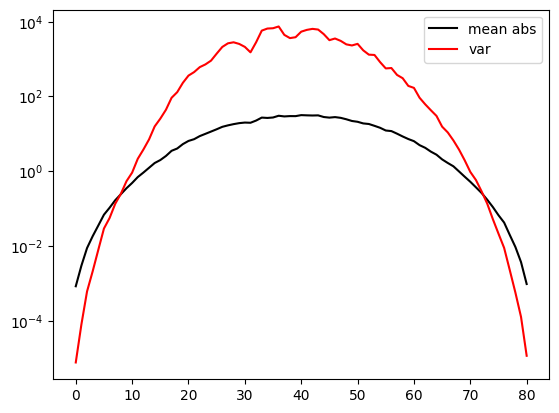

In [93]:
L = 10
k = 9
fan_in = 1
bound = 1.0 / math.sqrt(fan_in)
seed = 0
torch.manual_seed(seed)

k_eff_col = []
for repeats in range(1000):
    kernels = (torch.rand(L, k, dtype=torch.double) * 2 - 1) * bound
    k_eff = torch.ones(1, dtype=torch.double)
    for i in range(L):
        k_eff = compose_1d(k_eff, kernels[i])
    k_eff_col.append(k_eff)
    
k_eff_col = torch.stack(k_eff_col, dim=0)
plt.figure()
plt.plot(k_eff_col.abs().mean(dim=0), label='mean abs', c='k')
plt.plot(k_eff_col.var(dim=0), label='var', c='r')
plt.yscale('log')
plt.legend()

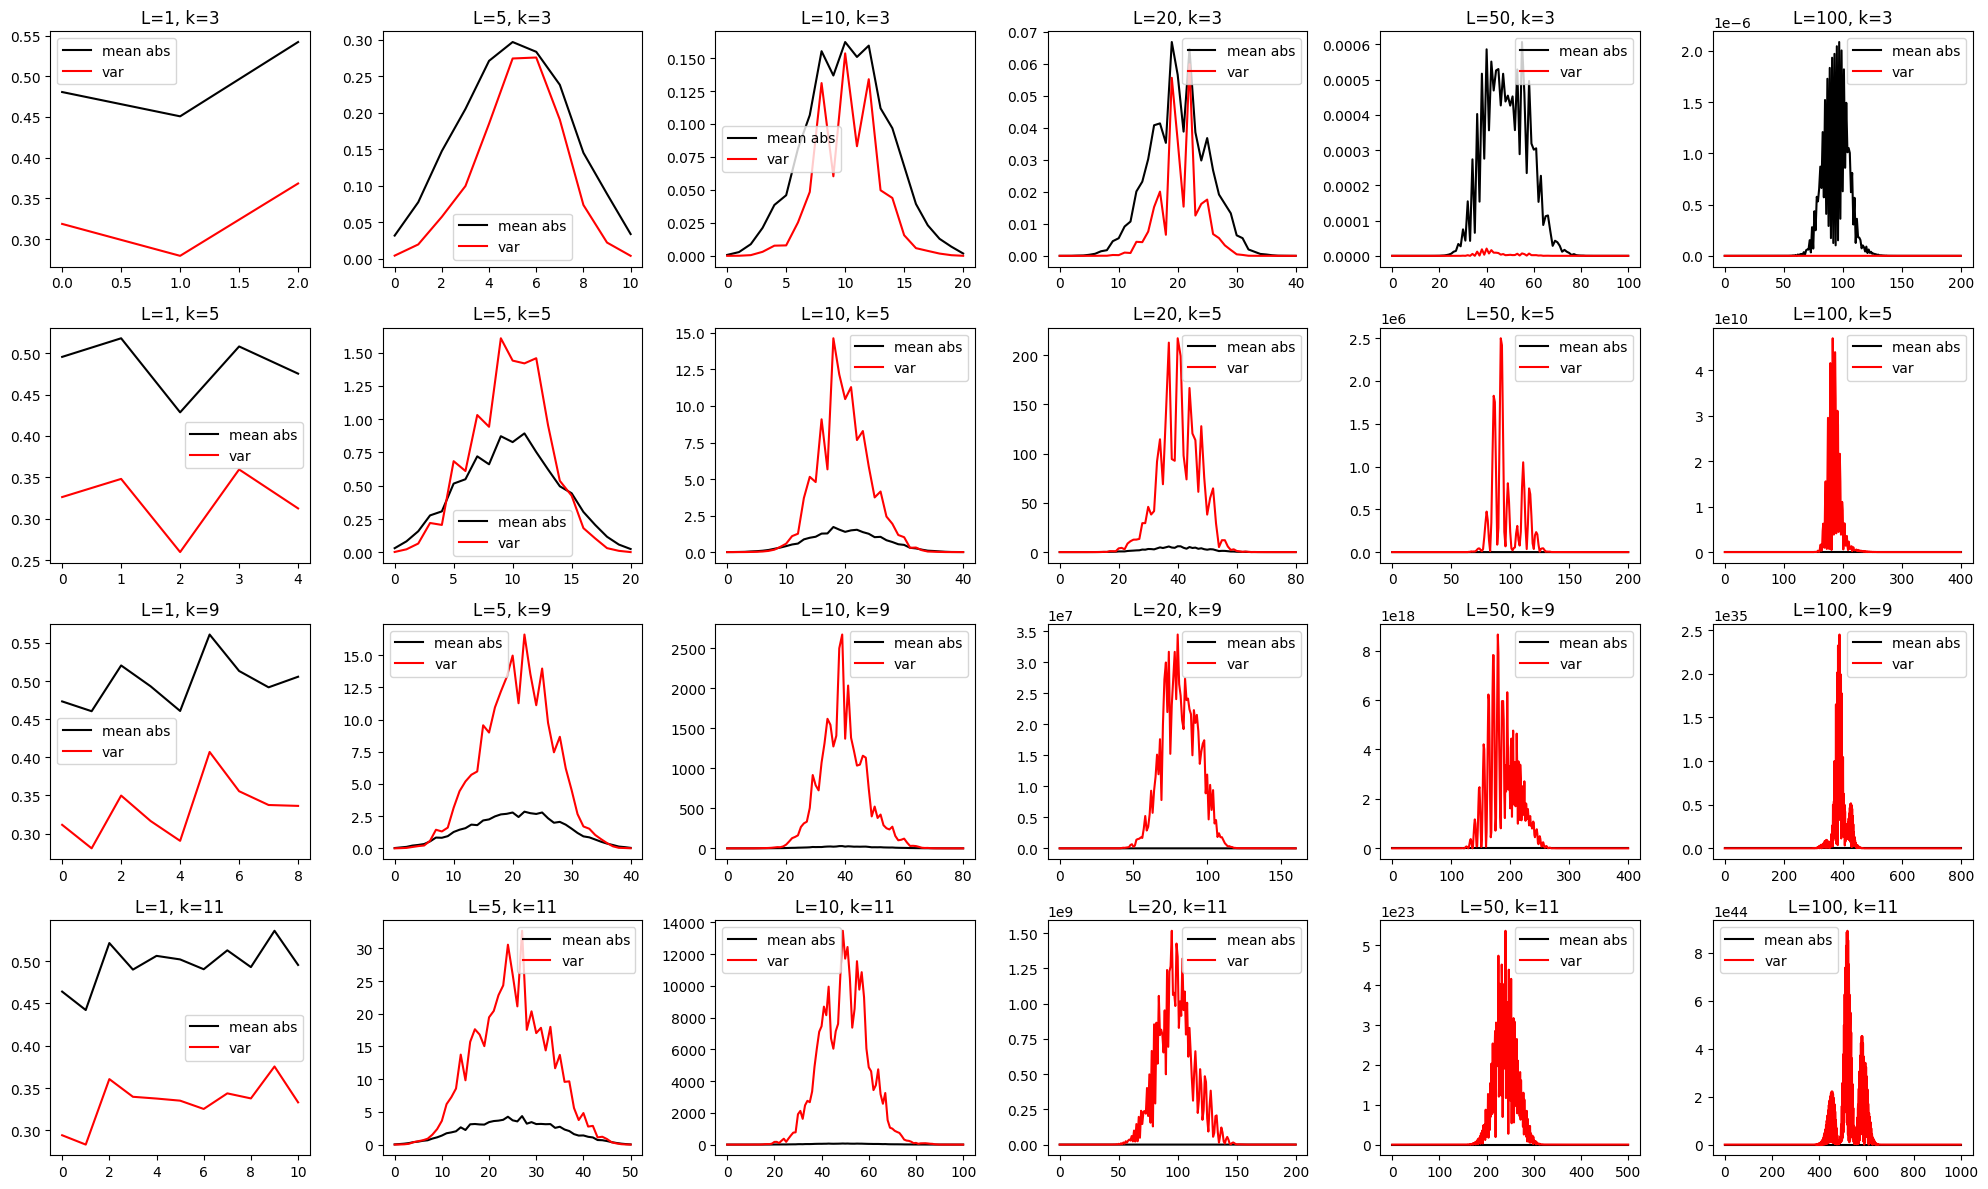

In [ ]:
L_values = [1, 5, 10, 20, 50, 100]
k_values = [3, 5, 9, 11]
fig, axes = plt.subplots(len(k_values), len(L_values), figsize=(20, 12))
for i, k in enumerate(k_values):
    for j, L in enumerate(L_values):
        k_eff_col = simulate_stack_conv1d(L, k, 1.0 / math.sqrt(k), 0, 100)
        axes[i, j].plot(k_eff_col.abs().mean(dim=0), label='mean abs', c='k')
        axes[i, j].plot(k_eff_col.var(dim=0), label='var', c='r')
        axes[i, j].legend()
        axes[i, j].set_title(f'L={L}, k={k}')
plt.tight_layout()
plt.show()

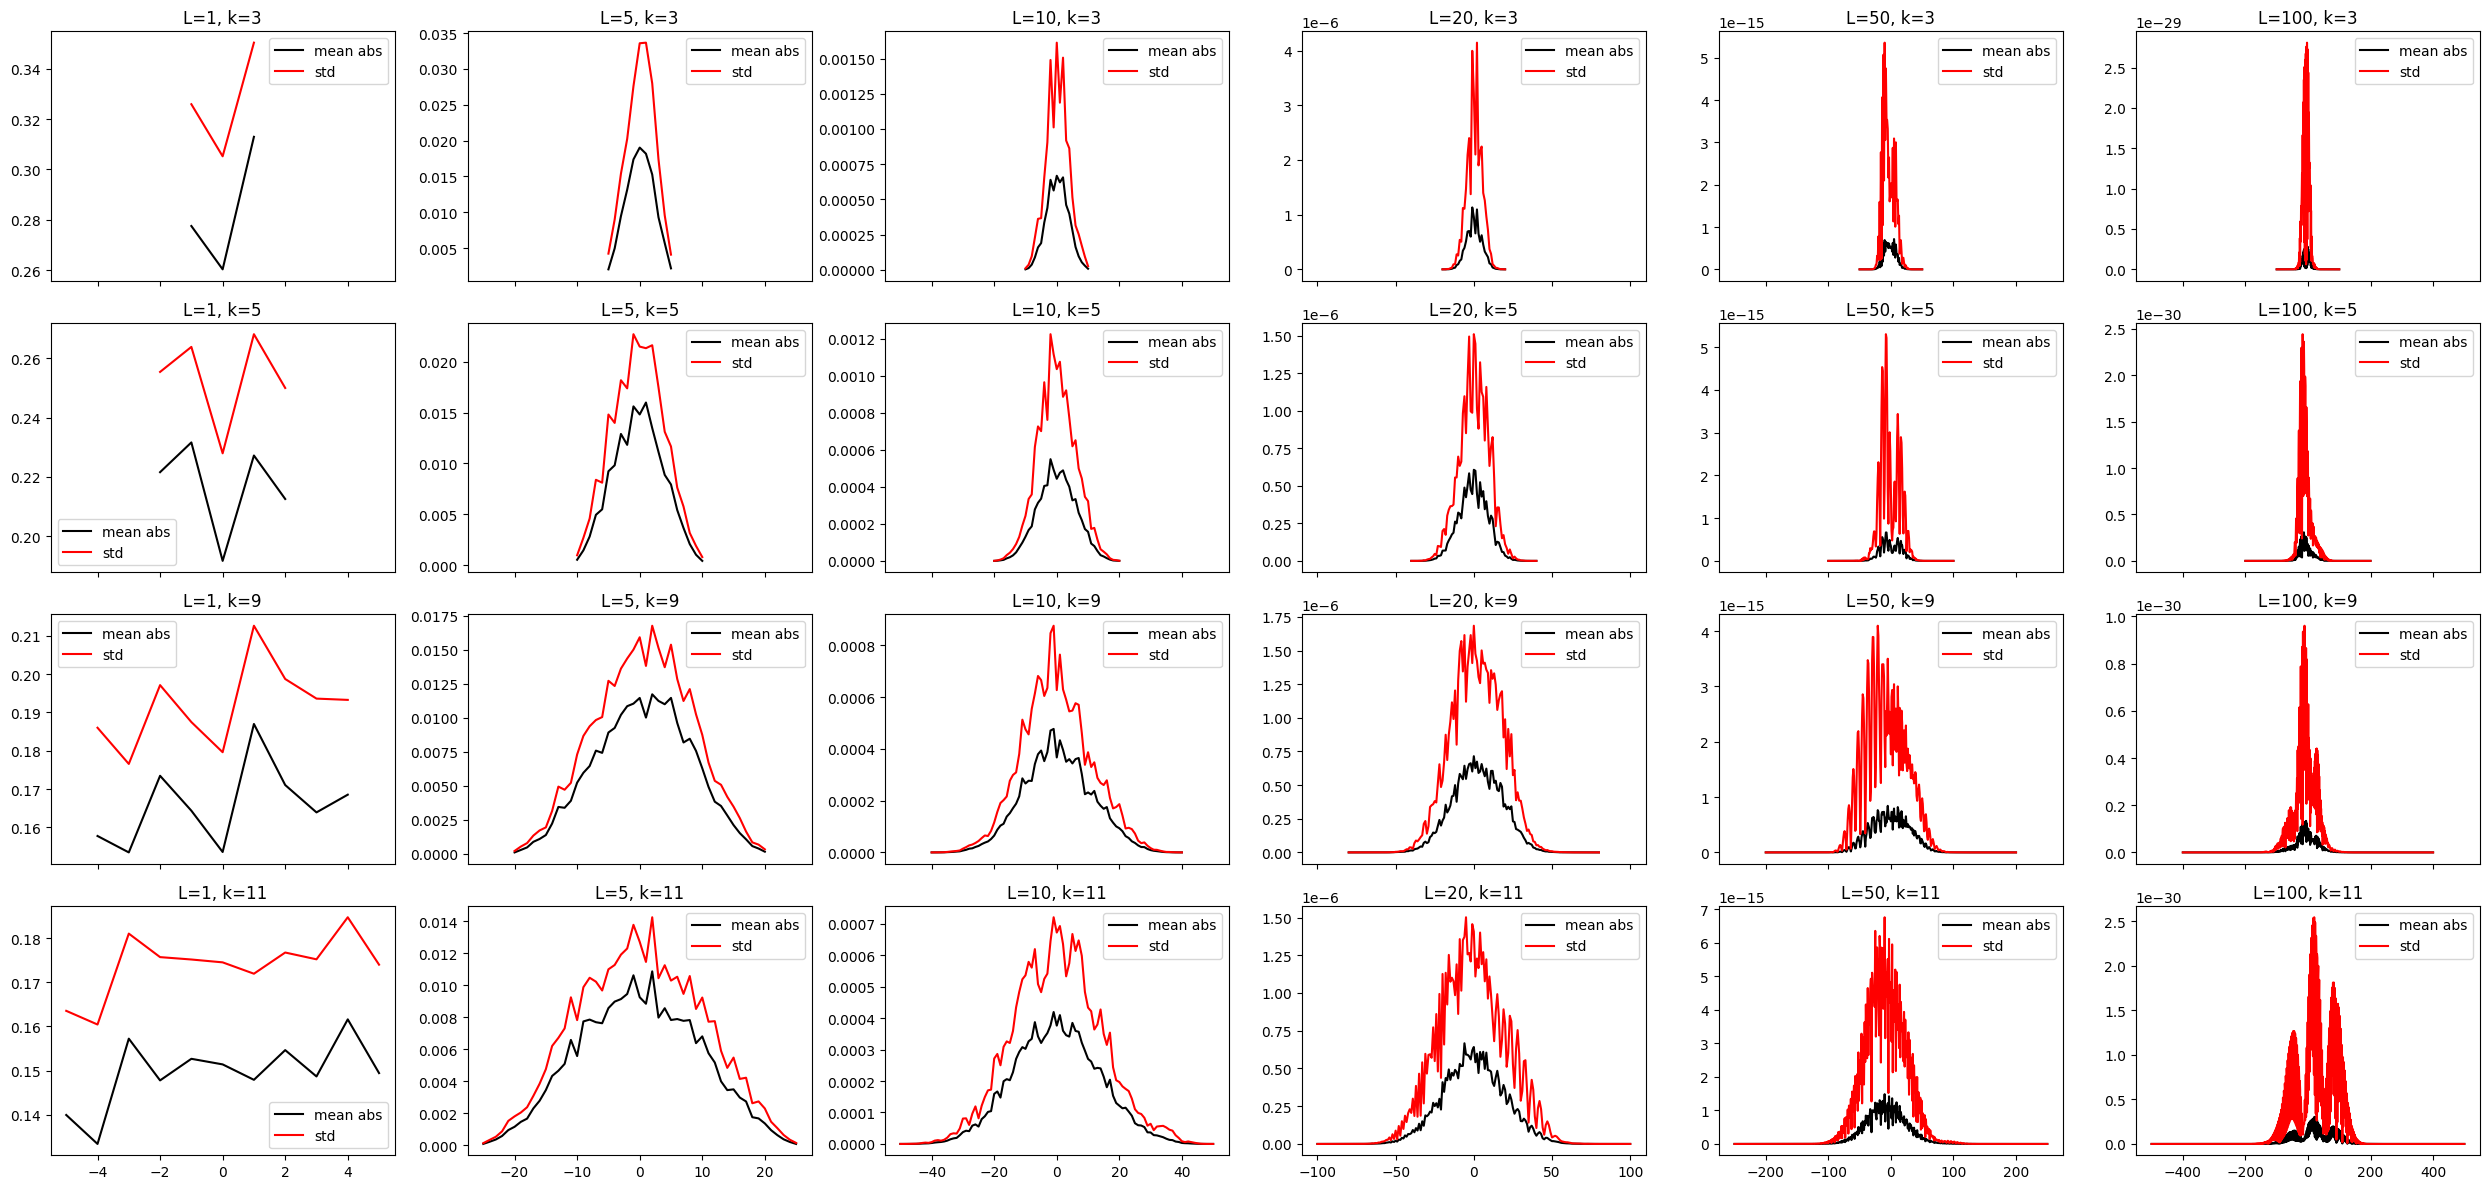

In [121]:
L_values = [1, 5, 10, 20, 50, 100]
k_values = [3, 5, 9, 11]
fig, axes = plt.subplots(len(k_values), len(L_values), figsize=(25, 12), sharex="col", sharey=False)
for i, k in enumerate(k_values):
    for j, L in enumerate(L_values):
        k_eff_col = simulate_stack_conv1d(L, k, 1.0 / math.sqrt(k), 0, 100)
        xvec = np.arange(k_eff_col.size(1))
        xvec = xvec - k_eff_col.size(1) // 2
        axes[i, j].plot(xvec, k_eff_col.abs().mean(dim=0), label='mean abs', c='k')
        axes[i, j].plot(xvec, k_eff_col.std(dim=0), label='std', c='r')
        axes[i, j].legend()
        axes[i, j].set_title(f'L={L}, k={k}')
plt.tight_layout()
plt.show()

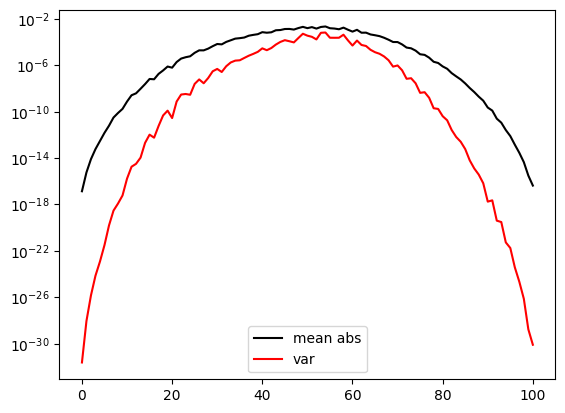

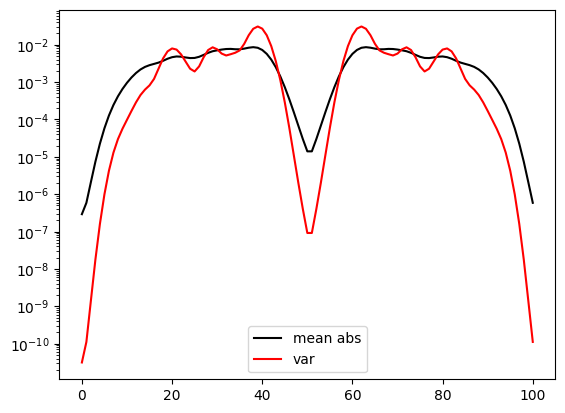

In [81]:
L = 50 
k = 3 
fan_in = 3
bound = 1.0 #/ math.sqrt(fan_in)
seed = 0
torch.manual_seed(seed)
k_eff_col = []
k_eff_col_freq = []
for repeats in range(1000):
    kernels = (torch.rand(L, k) * 2 - 1) * bound
    k_eff = torch.ones(1)
    for i in range(L):
        k_eff = compose_1d(k_eff, kernels[i])
    # compute the frequency response too 
    k_eff_col.append(k_eff)
    k_eff_fft = torch.fft.fft(k_eff) # torch.fft.fftshift(
    k_eff_col_freq.append(k_eff_fft)

k_eff_col = torch.stack(k_eff_col, dim=0)
k_eff_col_freq = torch.stack(k_eff_col_freq, dim=0)

plt.figure()
plt.plot(k_eff_col.abs().mean(dim=0), label='mean abs', c='k')
plt.plot(k_eff_col.var(dim=0), label='var', c='r')
plt.yscale('log')
plt.legend()
plt.show()
plt.figure()
plt.plot(k_eff_col_freq.abs().mean(dim=0), label='mean abs', c='k')
plt.plot(k_eff_col_freq.var(dim=0), label='var', c='r')
plt.yscale('log')
plt.legend()
plt.show()

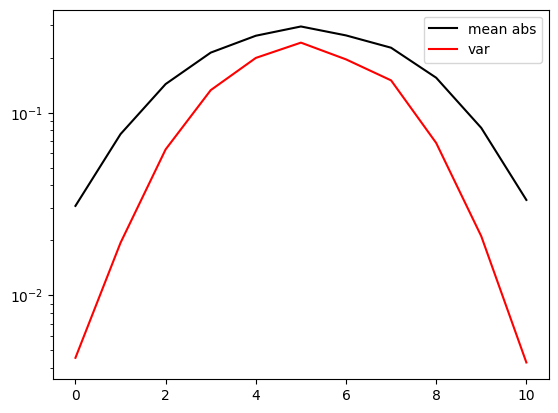

In [39]:

# --- Parameters ---
L = 5           # number of layers
k = 3           # kernel width
fan_in = 3
bound = 1.0 # / math.sqrt(fan_in)      # uniform range [-bound, +bound] # / math.sqrt(fan_in)
seed = 42
torch.manual_seed(seed)
# 1) Sample L random kernels
# shape = (L, k)
eff_kernels = []
for repeats in range(1000):
    kernels = (torch.rand(L, k) * 2 - 1) * bound
    # 2) Compute effective kernel
    eff_kernel = compute_effective_kernel(kernels)
    eff_kernels.append(eff_kernel)
eff_kernels = torch.stack(eff_kernels, dim=0)
plt.figure()
plt.plot(eff_kernels.abs().mean(dim=0), label='mean abs', c='k')
plt.plot(eff_kernels.var(dim=0), label='var', c='r')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def compute_effective_kernel(kernels: torch.Tensor) -> torch.Tensor:
    """
    Given `kernels` of shape (L, k),
    returns the full convolution of all L kernels,
    which has length 1 + L*(k-1).
    """
    # start from the first kernel as a (batch=1,channels=1,length=k) tensor
    eff = kernels[0].view(1, 1, -1)
    for i in range(1, kernels.size(0)):
        k_i = kernels[i].view(1, 1, -1)
        # full convolution: length_out = length_in + k_i - 1
        eff = F.conv_transpose1d(eff, k_i)
    return eff.view(-1)

# --- Parameters ---
L = 5           # number of layers
k = 3           # kernel width
bound = 1.0     # uniform range [-bound, +bound]
seed = 42
torch.manual_seed(seed)

# 1) Sample L random kernels
# shape = (L, k)
kernels = (torch.rand(L, k) * 2 - 1) * bound

# 2) Compute effective kernel
eff_kernel = compute_effective_kernel(kernels)

# # 3) Plot
# fig, axes = plt.subplots(L+1, 1, figsize=(6, 2*(L+1)), sharex=False)

# for i in range(L):
#     axes[i].stem(kernels[i].numpy(), )
#     axes[i].set_ylabel(f'k{i+1}')
#     axes[i].set_ylim(-bound, bound)

# axes[L].stem(eff_kernel.numpy(), )
# axes[L].set_ylabel('effective')
# axes[L].set_xlabel('time / space index')

# plt.tight_layout()
# plt.show()

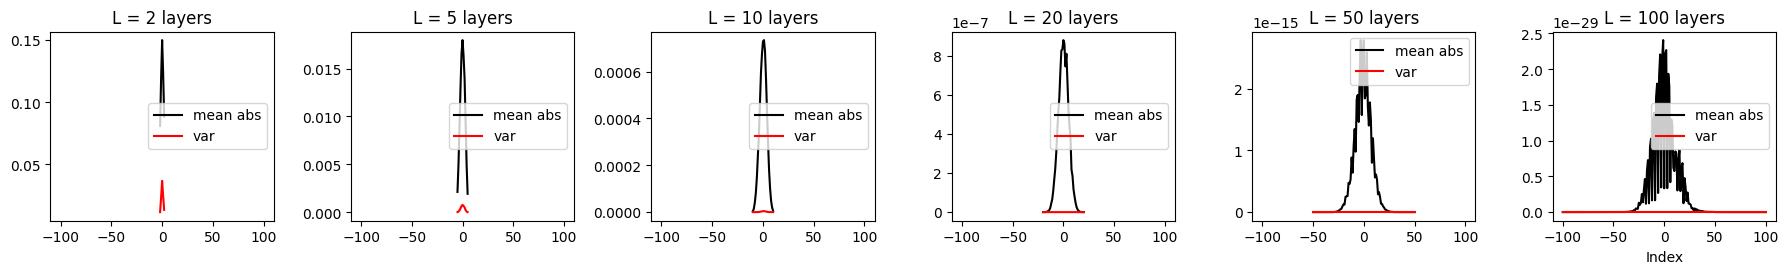

In [51]:
# --- Parameters ---
k = 3           # kernel width
fan_in = 3
bound = 1.0  / math.sqrt(fan_in)      # uniform range [-bound, +bound] # / math.sqrt(fan_in)
seed = 42
torch.manual_seed(seed)
# Plot different L values in different panels
L_values = [2, 5, 10, 20, 50, 100]  # different numbers of layers to test
fig, axes = plt.subplots(1, len(L_values), 
                         figsize=(3*len(L_values), 3), 
                         sharex=True, sharey=False)
for i, L in enumerate(L_values):
    # 1) Sample L random kernels for each L value
    eff_kernels = []
    for repeats in range(1000):
        kernels = (torch.rand(L, k) * 2 - 1) * bound
        # 2) Compute effective kernel
        eff_kernel = compute_effective_kernel(kernels)
        eff_kernels.append(eff_kernel)
    eff_kernels = torch.stack(eff_kernels, dim=0)
    # Plot in the corresponding panel
    ax = axes[i]
    xvec = np.arange(eff_kernels.size(1))
    xvec = xvec - eff_kernels.size(1) // 2
    ax.plot(xvec, eff_kernels.abs().mean(dim=0), label='mean abs', c='k')
    ax.plot(xvec, eff_kernels.var(dim=0), label='var', c='r')
    # ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'L = {L} layers')
    # Only add x-label to the bottom subplot
    if i == len(L_values) - 1:
        ax.set_xlabel('Index')

plt.tight_layout()

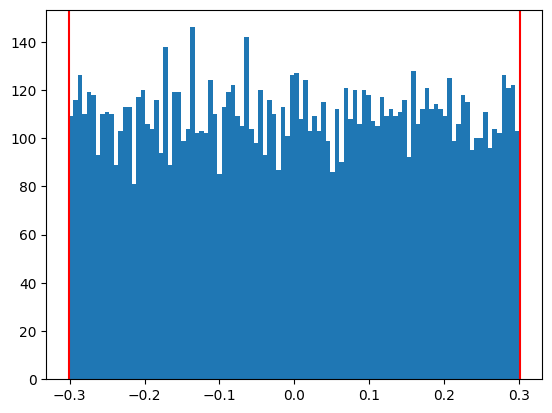

In [108]:
ker_size = 11
weights_col = []
for repeats in range(1000):
    dummy_conv1 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=ker_size, stride=1, padding=1)
    weights_col.append(dummy_conv1.weight.data.squeeze())
weights_col = torch.stack(weights_col, dim=0)
plt.hist(weights_col.flatten(), bins=100)
plt.axvline(x=1/math.sqrt(ker_size), c='r', label=f'1/sqrt({ker_size})')
plt.axvline(x=-1/math.sqrt(ker_size), c='r', label=f'-1/sqrt({ker_size})')
plt.show()